In [1]:
# import system libs
import os
import time
import random
import math
import pathlib
import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

# Reading Data

In [2]:
# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    train_df, dummy_df = train_test_split(df, train_size= 0.8)
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [3]:
def create_gens(df, aug_dict):
    img_size = (256, 256)
    batch_size = 32

    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix= 'mask', seed=1)

    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:
        img = img / 255
        msk = msk / 255
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)

In [4]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path)
        
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

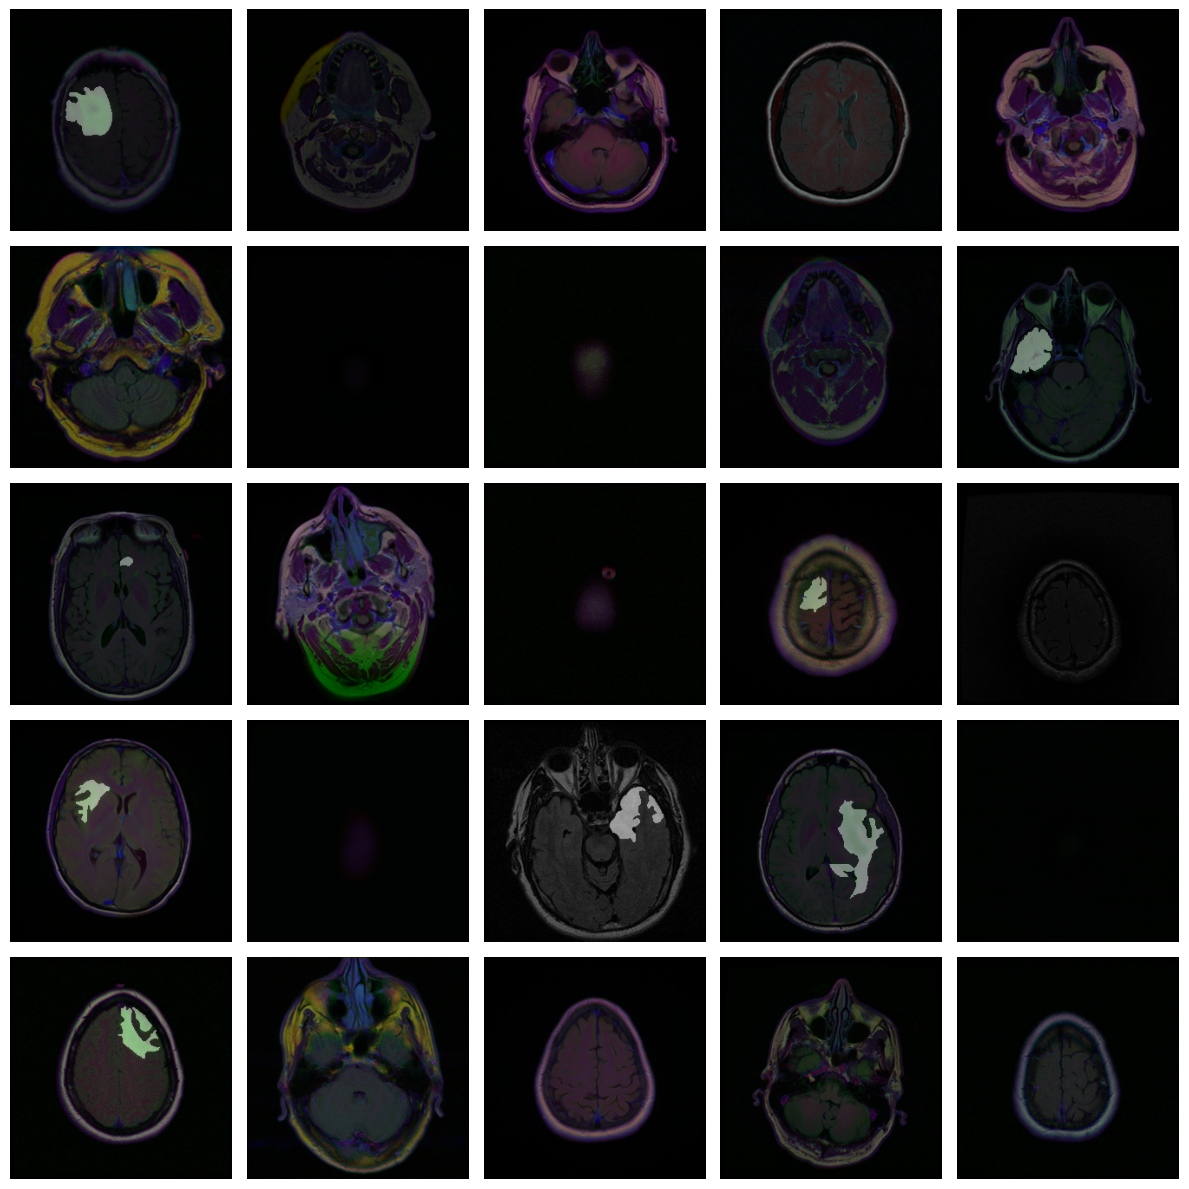

In [5]:
data_dir = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)


tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')


train_gen = create_gens(train_df, aug_dict=tr_aug_dict)
valid_gen = create_gens(valid_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})

show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

# Model

## Importing Libaries 

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate

2025-09-27 14:50:12.646498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-27 14:50:12.646616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-27 14:50:12.790378: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## U-Net

In [7]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [8]:
def encoder_block(input, num_filters):
    s = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(s)
    return s, p

In [9]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [10]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

## Metrics & Loss function

In [11]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [12]:
# Dice Loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [13]:
model = build_unet((256, 256, 3))
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics= ['accuracy', iou_coef, dice_coef])
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

# Training

In [14]:
epochs = 120
batch_size = 32

callbacks = [
    ModelCheckpoint(
        'segmentation_brain_tumor_best.keras',
        monitor='val_dice_coef',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_dice_coef',
        mode='max',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]


history = model.fit(train_gen,
                    steps_per_epoch=math.ceil(len(train_df) / batch_size),
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data = valid_gen,
                    validation_steps=math.ceil(len(train_df) / batch_size))

Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/120


2025-09-27 14:51:04.112730: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2025-09-27 14:51:04.143276: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.31777, expected 2.61172
2025-09-27 14:51:04.143342: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 5.10329, expected 4.39724
2025-09-27 14:51:04.143357: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.80913, expected 4.10308
2025-09-27 14:51:04.143372: E external/local_xla/xla/service/gpu/buffer_comparato

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.8185 - dice_coef: 0.0680 - iou_coef: 0.0358 - loss: 0.9320

2025-09-27 14:54:24.362611: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.25123, expected 1.72077
2025-09-27 14:54:24.362677: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.77769, expected 3.24723
2025-09-27 14:54:24.362687: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.77422, expected 3.24376
2025-09-27 14:54:24.362695: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.96997, expected 3.43951
2025-09-27 14:54:24.362703: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.84384, expected 3.31338
2025-09-27 14:54:24.362711: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.27249, expected 3.74204
2025-09-27 14:54:24.362719: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 3.54531, expected 3.01485
2025-09-27 14:54:24.362727: E external/local_xla/xla/se

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8194 - dice_coef: 0.0684 - iou_coef: 0.0360 - loss: 0.9316   Found 393 validated image filenames.
Found 393 validated image filenames.


2025-09-27 14:55:02.244376: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.61827, expected 2.62157
2025-09-27 14:55:02.244439: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.51962, expected 4.52292
2025-09-27 14:55:02.244458: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.53584, expected 4.53914
2025-09-27 14:55:02.244473: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.94599, expected 5.94929
2025-09-27 14:55:02.244485: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 7.73571, expected 6.73901
2025-09-27 14:55:02.244496: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.13476, expected 6.13806
2025-09-27 14:55:02.244506: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.95982, expected 5.96312
2025-09-27 14:55:02.244517: E external/local_xla/xla/se


Epoch 1: val_dice_coef improved from -inf to 0.02132, saving model to segmentation_brain_tumor_best.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.8202 - dice_coef: 0.0687 - iou_coef: 0.0362 - loss: 0.9313 - val_accuracy: 0.0180 - val_dice_coef: 0.0213 - val_iou_coef: 0.0108 - val_loss: 0.9785
Epoch 2/120
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.9852 - dice_coef: 0.1780 - iou_coef: 0.0984 - loss: 0.8220
Epoch 2: val_dice_coef improved from 0.02132 to 0.03512, saving model to segmentation_brain_tumor_best.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 98s 997ms/step - accuracy: 0.9852 - dice_coef: 0.1781 - iou_coef: 0.0985 - loss: 0.8219 - val_accuracy: 0.9866 - val_dice_coef: 0.0351 - val_iou_coef: 0.0179 - val_loss: 0.9643
Epoch 3/120
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.9885 - dice_coef: 0.2301 - iou_coef: 0.1319 - loss: 0.7699
Epoch 3: val_dice_coef improved from 0.03512 to 0.05370, saving model to segmentation_brain_tumor_best.keras
99/99 ━━━━━━━━━━━

# Prediction

2025-09-27 16:24:43.662279: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.86272, expected 2.0465
2025-09-27 16:24:43.662354: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.04967, expected 3.23345
2025-09-27 16:24:43.662364: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.4326, expected 3.61638
2025-09-27 16:24:43.662372: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.46868, expected 4.65247
2025-09-27 16:24:43.662380: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.37814, expected 4.56193
2025-09-27 16:24:43.662388: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.18374, expected 4.36753
2025-09-27 16:24:43.662396: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.54872, expected 4.7325
2025-09-27 16:24:43.662404: E external/local_xla/xla/servi

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


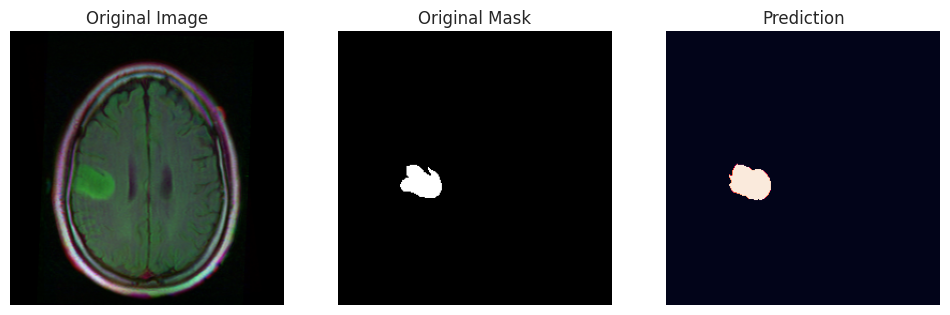

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


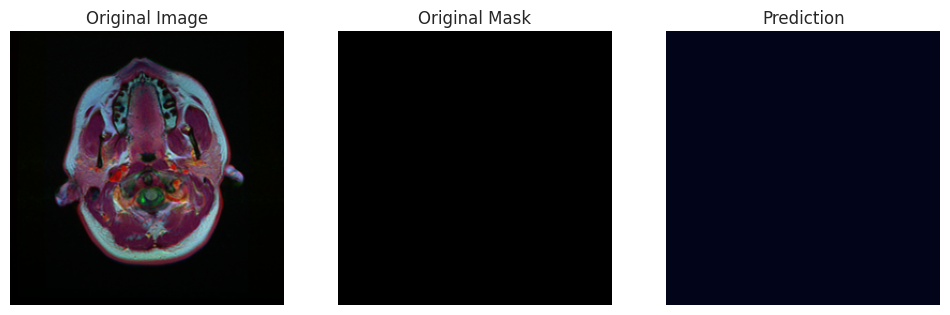

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


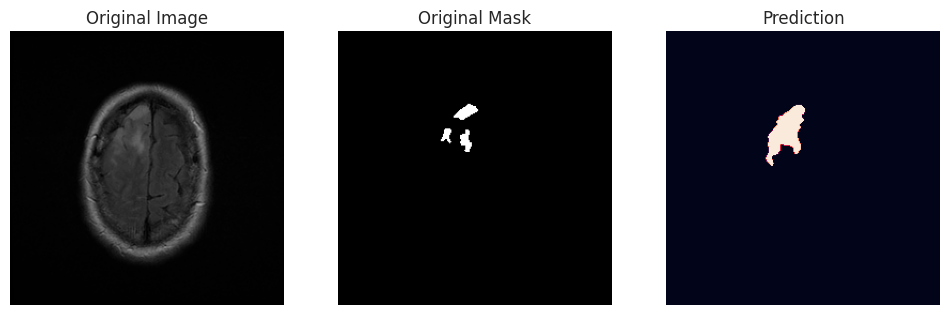

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


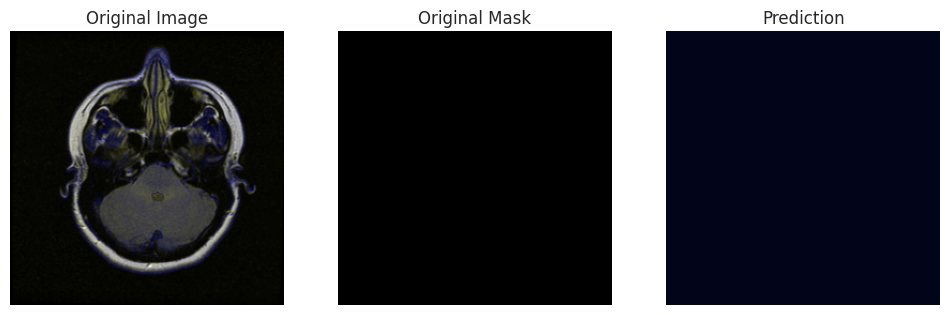

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


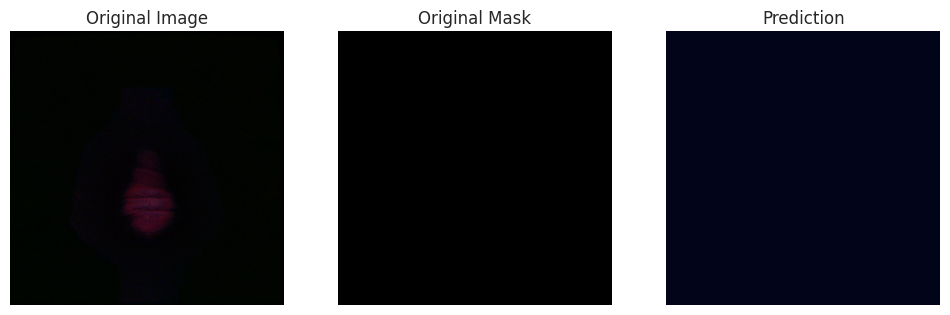

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


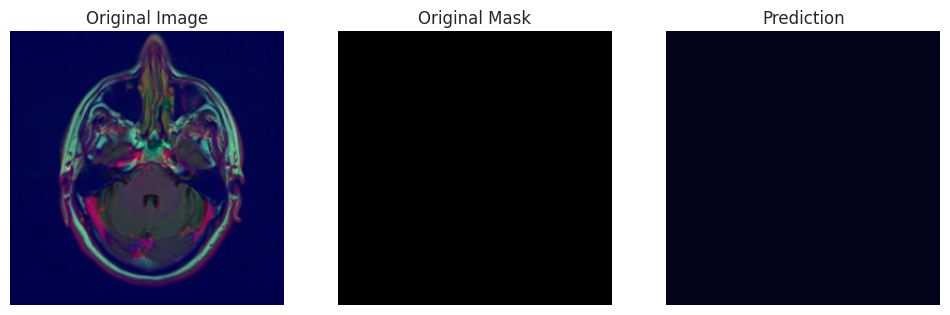

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


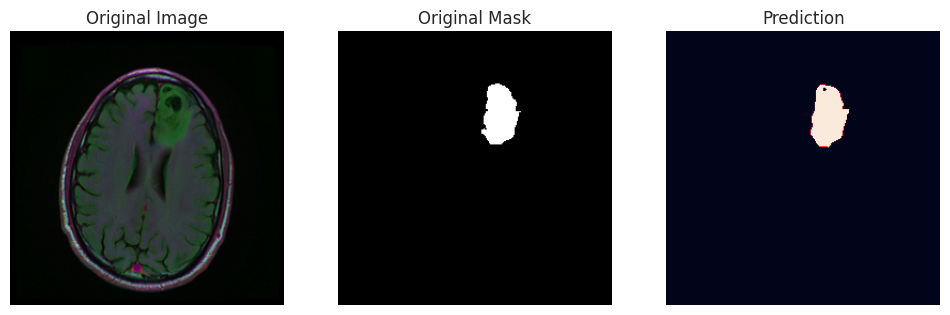

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


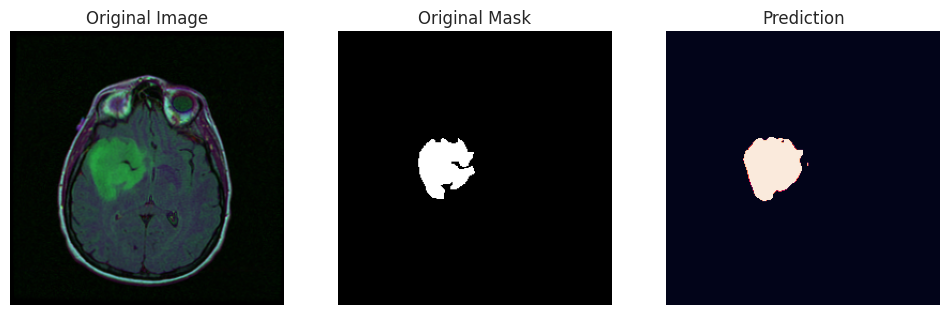

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


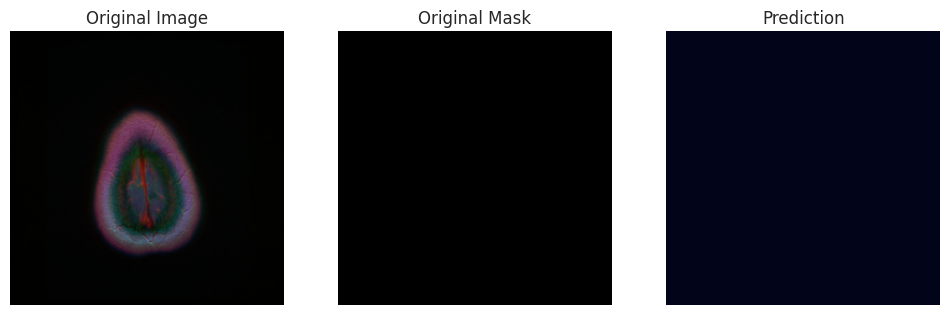

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


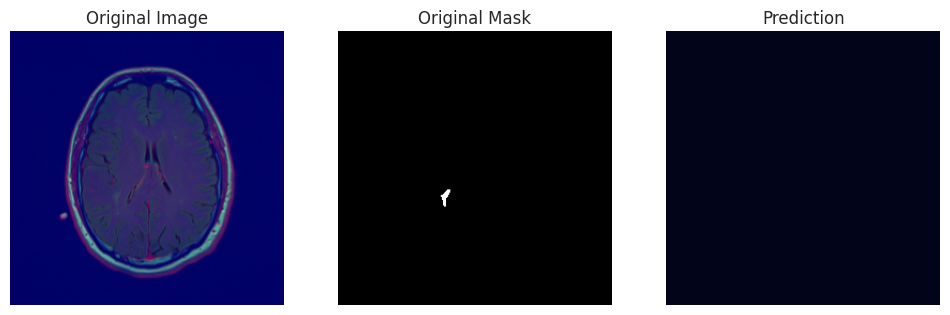

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


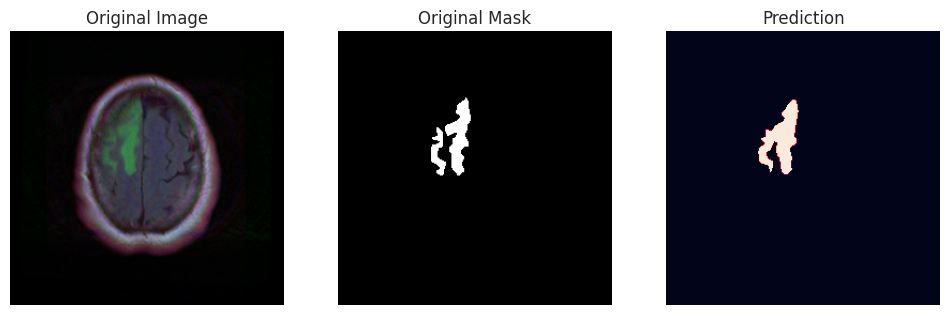

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


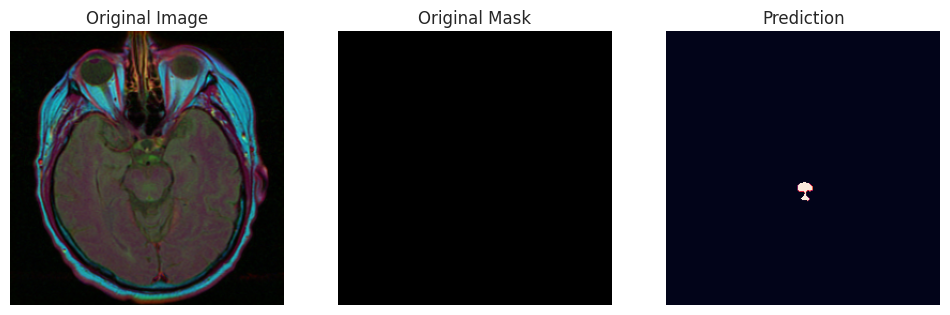

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


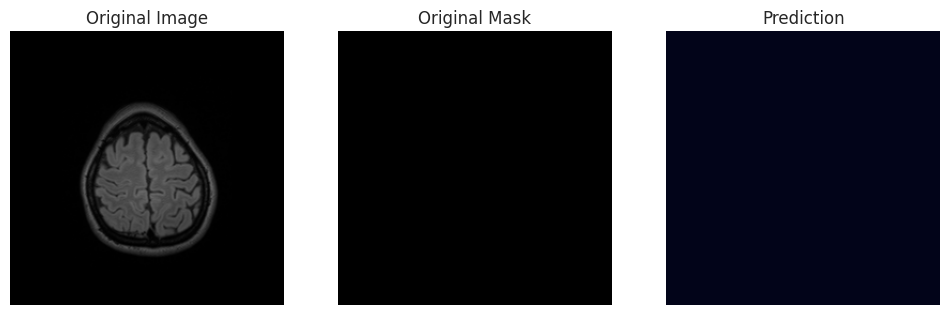

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


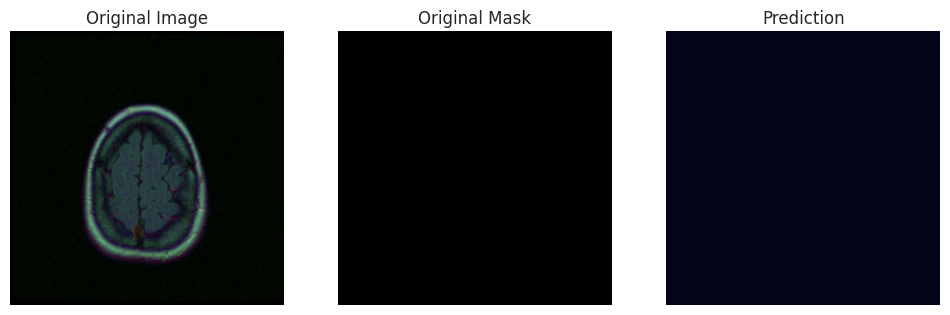

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


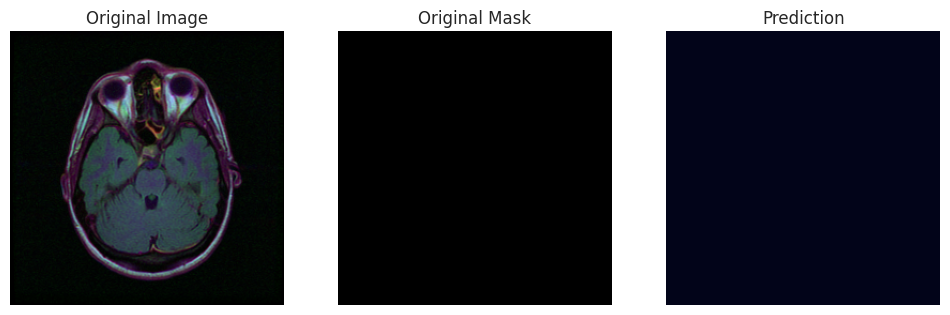

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


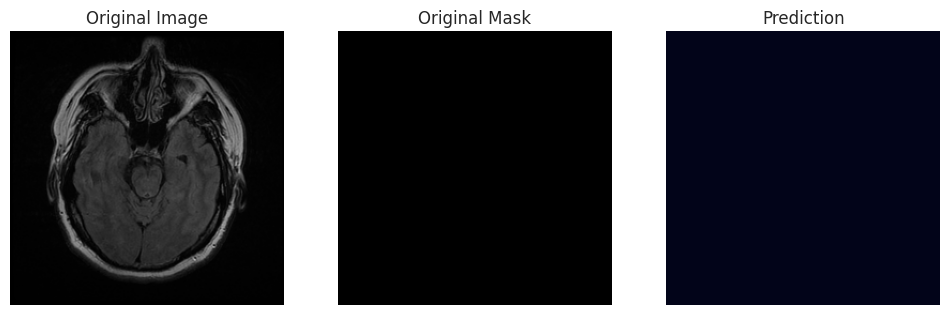

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


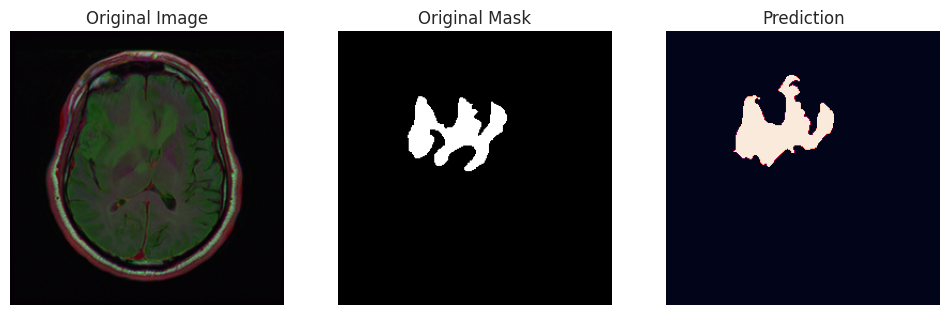

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


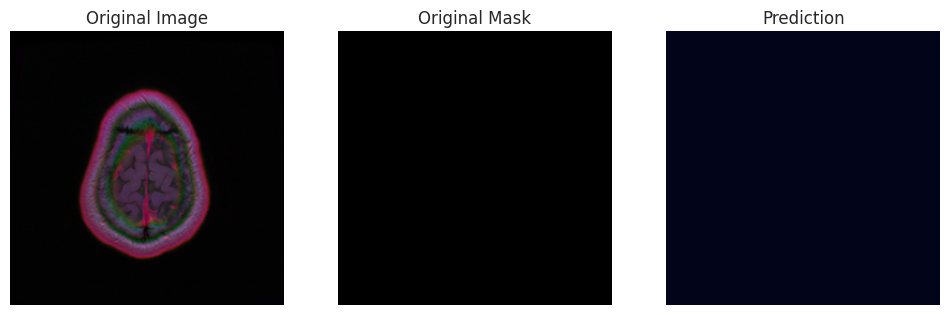

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


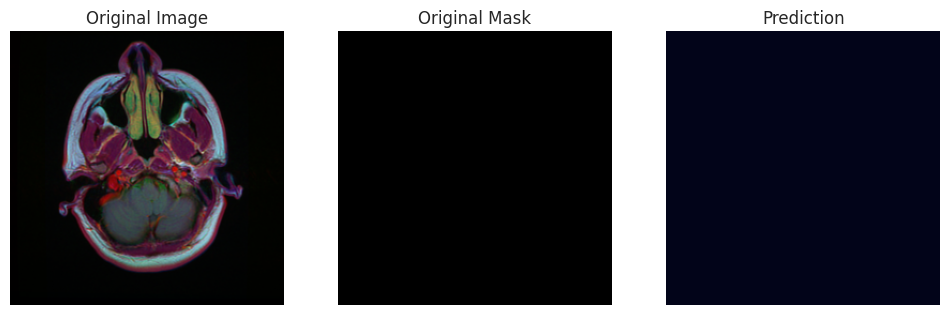

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


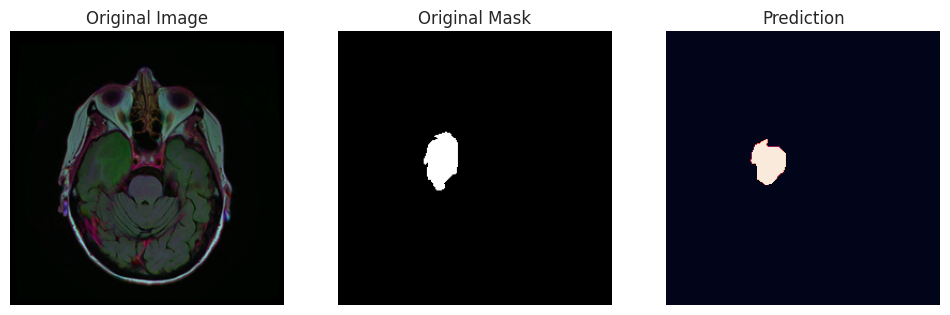

In [15]:
for _ in range(20):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))

    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')

    plt.show()

# Evaluation

In [16]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])

131/131 ━━━━━━━━━━━━━━━━━━━━ 80s 611ms/step - accuracy: 0.9983 - dice_coef: 0.9065 - iou_coef: 0.8301 - loss: 0.0934
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 250ms/step - accuracy: 0.9975 - dice_coef: 0.8740 - iou_coef: 0.7786 - loss: 0.1247
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - accuracy: 0.9977 - dice_coef: 0.8934 - iou_coef: 0.8086 - loss: 0.1047
Train Loss:  0.09558378159999847
Train Accuracy:  0.998257577419281
Train IoU:  0.8261620402336121
Train Dice:  0.9042486548423767
--------------------
Valid Loss:  0.12523677945137024
Valid Accuracy:  0.9975370764732361
Valid IoU:  0.7780628204345703
Valid Dice:  0.8737772703170776
--------------------
Test Loss:  0.10562276095151901
Test Accuracy:  0.9976374506950378
Test IoU:  0.80669105052948
Test Dice:  0.892083466053009
